# Data Acquisition

In [20]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
import re
import xlsxwriter
from dateutil import parser
import statsmodels.api as sm
from scipy.stats import f as f_dist
from scipy import stats
import io, zipfile, requests

def load_25_ew_monthly() -> pd.DataFrame:
    u = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/25_Portfolios_5x5_CSV.zip"
    L = zipfile.ZipFile(io.BytesIO(requests.get(u, timeout=30).content)).read(
            zipfile.ZipFile(io.BytesIO(requests.get(u, timeout=30).content)).namelist()[0]
        ).decode("utf-8", errors="replace").replace("\u2013","-").replace("\u2014","-").splitlines()
    m = next(i for i,l in enumerate(L)
             if re.search(r"^\s*Average\s+Equal\s+Weighted\s+Returns\s*-\s*-\s*Monthly\s*$", l, re.I))
    h = next(i for i in range(m+1, len(L)) if L[i].strip())
    j = next(i for i in range(h+1, len(L)) if not L[i].strip())
    df = pd.read_csv(io.StringIO("\n".join(L[h:j])), index_col=0, skipinitialspace=True)
    idx = pd.to_datetime(df.index.astype(str), format="%Y%m", errors="coerce")
    if idx.isna().any(): idx = pd.to_datetime(df.index.astype(str), errors="coerce")
    df = df.loc[~idx.isna()].copy()
    df.index = pd.PeriodIndex(idx[~idx.isna()], freq="M")
    df.columns = [c.strip() for c in df.columns]
    return df 

def load_ff3_monthly() -> pd.DataFrame:
    u = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    z = zipfile.ZipFile(io.BytesIO(requests.get(u, timeout=30).content))
    L = z.read(z.namelist()[0]).decode("utf-8", errors="replace").splitlines()
    h = next(i for i,l in enumerate(L) if ("Mkt-RF" in l and "SMB" in l and "HML" in l and "RF" in l and "," in l))
    j = h + 1
    while j < len(L) and L[j].strip(): j += 1
    ff3 = pd.read_csv(io.StringIO("\n".join(L[h:j])), index_col=0, skipinitialspace=True)
    idx = pd.to_datetime(ff3.index.astype(str), format="%Y%m", errors="coerce")
    if idx.isna().any(): idx = pd.to_datetime(ff3.index.astype(str), errors="coerce")
    ff3 = ff3.loc[~idx.isna()].copy()
    ff3.index = pd.PeriodIndex(idx[~idx.isna()], freq="M")
    ff3.columns = [c.strip() for c in ff3.columns]
    return ff3 

In [21]:
_PATTERNS = [
    # YYYY-month
    (re.compile(r"^\s*\d{4}-\d{1,2}\s*$"),                  "%Y-%m"),
    (re.compile(r"^\s*\d{4}/\d{1,2}\s*$"),                  "%Y/%m"),
    (re.compile(r"^\s*\d{4}\.\d{1,2}\s*$"),                 "%Y.%m"),
    (re.compile(r"^\s*\d{4}\s+\d{1,2}\s*$"),                "%Y %m"),
    # month-YYYY
    (re.compile(r"^\s*\d{1,2}/\d{4}\s*$"),                  "%m/%Y"),
    (re.compile(r"^\s*\d{1,2}-\d{4}\s*$"),                  "%m-%Y"),
    (re.compile(r"^\s*\d{1,2}\s+\d{4}\s*$"),                "%m %Y"),
    # long/short month names with year
    (re.compile(r"^\s*[A-Za-z]{3}-\d{4}\s*$"),              "%b-%Y"),
    (re.compile(r"^\s*[A-Za-z]{3}/\d{4}\s*$"),              "%b/%Y"),
    (re.compile(r"^\s*[A-Za-z]{3}\s+\d{4}\s*$"),            "%b %Y"),
    (re.compile(r"^\s*[A-Za-z]+-\d{4}\s*$"),                "%B-%Y"),
    (re.compile(r"^\s*[A-Za-z]+/\d{4}\s*$"),                "%B/%Y"),
    (re.compile(r"^\s*[A-Za-z]+\s+\d{4}\s*$"),              "%B %Y"),
    # reversed: year then month name
    (re.compile(r"^\s*\d{4}-[A-Za-z]{3}\s*$"),              "%Y-%b"),
    (re.compile(r"^\s*\d{4}\s+[A-Za-z]{3}\s*$"),            "%Y %b"),
    (re.compile(r"^\s*\d{4}-[A-Za-z]+\s*$"),                "%Y-%B"),
    (re.compile(r"^\s*\d{4}\s+[A-Za-z]+\s*$"),              "%Y %B"),
    # full dates (normalize to that month)
    (re.compile(r"^\s*\d{4}-\d{1,2}-\d{1,2}\s*$"),          "%Y-%m-%d"),
    (re.compile(r"^\s*\d{1,2}/\d{1,2}/\d{4}\s*$"),          "%m/%d/%Y"),
    (re.compile(r"^\s*\d{4}/\d{1,2}/\d{1,2}\s*$"),          "%Y/%m/%d"),
]
RE_YYYYMM   = re.compile(r"^\s*(\d{4})(\d{2})\s*$")     # e.g., 200110 → Oct 2001


def parse_month_strict(s: str) -> pd.Period:
    s = s.strip()
    m = RE_YYYYMM.fullmatch(s)
    if m:
        y, mm = int(m.group(1)), int(m.group(2))
        return pd.Period(pd.Timestamp(y, mm, 1), freq="M")
    
    for pat, fmt in _PATTERNS:
        if pat.match(s):
            ts = pd.to_datetime(s, format=fmt, errors="raise")
            # Normalize to the month you intended
            p = pd.Period(ts, freq="M")
            return p
    raise ValueError()


def get_input_date(prompt, error_msg="Invalid month format. Try: YYYY-MM, YYYY/MM, YYYY.MM, YYYY MM, "
                     "MM/YYYY, MM-YYYY, YYYYMM, Mon-YYYY, Month YYYY, YYYY-Mon, or a full date like YYYY-MM-DD."):
    while True:
        s = input(prompt).strip()
        try:
            p = parse_month_strict(s)
            return p

        except Exception:
            print(error_msg)
            continue



def get_input(prompt, expected_type=str, allowed_values=None, error_msg="Invalid input."):
    while True:
        user_input = input(prompt).strip()

        if allowed_values is not None:
            if user_input.upper() in allowed_values:
                return user_input.upper()
            else:
                print(f"Please enter one of: {', '.join(allowed_values)}")
                continue

        try:
            return expected_type(user_input)
        except:
            print(error_msg)

            

def dates(f, p):
    while True:
        lo, hi = f.index.min(), p.index.max()
        starting_month = get_input_date("Please enter starting date: ")
        ending_month = get_input_date("Please enter ending date: ")
        if starting_month > ending_month:
            print(f"start > end after normalization: {starting_month} > {ending_month}. Please redo.")
            continue
        elif starting_month < lo or ending_month > hi:
            print(f"Requested range [{starting_month} → {ending_month}] is outside dataset coverage [{lo} → {hi}].")
            continue
        else:
            return starting_month,ending_month


            
def data_acquisition():
    p = load_25_ew_monthly()
    f = load_ff3_monthly()
    starting_month, ending_month = dates(f, p)
    ff3 = f.loc[(f.index >= starting_month) & (f.index <= ending_month)].copy()
    portfolios = p.loc[(p.index >= starting_month) & (p.index <= ending_month)].copy()
    
    model = get_input("Please input Model Choice (CAPM, FF3F, or Both): ", allowed_values = ['CAPM', 'FF3F', 'BOTH'])
    
    factors_dict = {}
    if model in ("CAPM", "BOTH"):
        factors_dict["CAPM"] = ff3[["Mkt-RF", "RF"]].copy()
    if model in ("FF3F", "BOTH"):
        factors_dict["FF3F"] = ff3[["Mkt-RF", "SMB", "HML", "RF"]].copy()
    
    # portfolios are ALREADY excess returns from Fama-French
    # So we use them directly as excess_ports
    excess_ports = portfolios.copy()
    
    # To get raw returns, ADD RF back
    base = ff3[["RF"]].copy()
    raw_ports = portfolios.add(base["RF"], axis=0)
    
    factors = pd.concat(factors_dict, axis=1)
    out = {
        'portfolios': raw_ports,           # RAW returns (for Fama-MacBeth)
        'excess_returns': excess_ports,    # EXCESS returns (for time-series)
        'factors': factors
    }
    return out

# Methodology and Computation

In [22]:
def run_time_series_regressions(excess_returns, raw_returns, factors, rf, model_type):
    
    # Get dimensions
    T = excess_returns.shape[0]
    N = excess_returns.shape[1]
    K = factors.shape[1]
    portfolio_names = excess_returns.columns
    factor_names = factors.columns
    
    # Extract RF series if needed
    if isinstance(rf, pd.DataFrame):
        rf_series = rf.iloc[:, 0]
    else:
        rf_series = rf
    
    # Compute portfolio statistics
    # Mean returns
    meanret = raw_returns.mean(axis=0)
    
    # Standard deviations
    stdret = raw_returns.std(axis=0)
    
    # Sharpe ratios = (mean return - mean rf) / std
    mean_rf = rf_series.mean()
    sharpe_ratios = (meanret - mean_rf) / stdret
    
    # Initialize storage for regression results
    alphas = pd.Series(index=portfolio_names, dtype=float)
    alpha_se = pd.Series(index=portfolio_names, dtype=float)
    alpha_t = pd.Series(index=portfolio_names, dtype=float)
    
    betas = pd.DataFrame(index=factor_names, columns=portfolio_names, dtype=float)
    beta_se = pd.DataFrame(index=factor_names, columns=portfolio_names, dtype=float)
    beta_t = pd.DataFrame(index=factor_names, columns=portfolio_names, dtype=float)
    
    r_squared = pd.Series(index=portfolio_names, dtype=float)
    residuals = pd.DataFrame(index=excess_returns.index, columns=portfolio_names, dtype=float)
    predicted = pd.DataFrame(index=excess_returns.index, columns=portfolio_names, dtype=float)
    
    # Add constant to factors for regression (this gives us alpha)
    X = sm.add_constant(factors)
    
    # Run regression for each portfolio (equivalent to LINEST in Excel)
    for port in portfolio_names:
        y = excess_returns[port]
        
        # Run OLS regression (this is what LINEST does)
        model = sm.OLS(y, X, missing='drop').fit()
        
        # Extract alpha (intercept) - corresponds to LINEST row 1
        alphas[port] = model.params['const']
        alpha_se[port] = model.bse['const']
        alpha_t[port] = model.tvalues['const']
        
        # Extract betas (factor loadings) - corresponds to LINEST subsequent rows
        for factor in factor_names:
            betas.loc[factor, port] = model.params[factor]
            beta_se.loc[factor, port] = model.bse[factor]
            beta_t.loc[factor, port] = model.tvalues[factor]
        
        # Store R²
        r_squared[port] = model.rsquared
        
        # Store residuals
        residuals[port] = model.resid
        
        # Calculate predicted values
        # predicted = MMULT(factors, betas) + alpha
        predicted[port] = model.fittedvalues
    
    return {
        'alphas': alphas,
        'betas': betas,
        'alpha_se': alpha_se,
        'alpha_t': alpha_t,
        'beta_se': beta_se,
        'beta_t': beta_t,
        'r_squared': r_squared,
        'residuals': residuals,
        'predicted': predicted,
        'meanret': meanret,
        'stdret': stdret,
        'sharpe_ratios': sharpe_ratios,
        'T': T,
        'N': N,
        'K': K
    }

In [23]:
def compute_grs_test(alphas, residuals, factors, T, N, K):
    
    # Convert to numpy arrays for Excel-style operations
    # alphas: (N x 1) vector
    alphas_array = alphas.values.reshape(N, 1)
    
    # resid: (T x N) matrix
    resid = residuals.values
    
    # factors: (T x K) matrix
    factors_array = factors.values
    
    # Step 1: Compute factor means
    # factormeans = AVERAGE(factors) for each column
    factormeans = factors_array.mean(axis=0).reshape(K, 1)  # (K x 1)
    
    # Step 2: Compute residual covariance matrix
    # rescovmat = MMULT(TRANSPOSE(resid), resid) / (T - K - 1)
    rescovmat = np.dot(resid.T, resid) / (T - K)  # (N x N)
    
    # Step 3: De-mean the factors
    # factoremat = factors - factormeans
    factoremat = factors_array - factormeans.T  # (T x K)
    
    # Step 4: Compute factor covariance matrix
    # factcovmat = MMULT(TRANSPOSE(factoremat), factoremat) / (T - 1)
    factcovmat = np.dot(factoremat.T, factoremat) / (T - K)  # (K x K)
    
    # Step 5: GRS F-statistic computation
    
    # Term 1: (T/N) * ((T-N-K)/(T-K-1))
    term1 = (T / N) * ((T - N - K) / (T - K - 1))
    
    # Term 2: MMULT(MMULT(alphas, MINVERSE(rescovmat)), TRANSPOSE(alphas))
    rescovmat_inv = np.linalg.inv(rescovmat)  # MINVERSE(rescovmat)
    temp = np.dot(alphas_array.T, rescovmat_inv)  # MMULT(TRANSPOSE(alphas), MINVERSE(rescovmat))
    term2 = np.dot(temp, alphas_array)[0, 0]  # MMULT(..., alphas)
    
    # Term 3: 1 + MMULT(MMULT(factormeans, MINVERSE(factcovmat)), TRANSPOSE(factormeans))
    factcovmat_inv = np.linalg.inv(factcovmat)  # MINVERSE(factcovmat)
    temp2 = np.dot(factormeans.T, factcovmat_inv)  # MMULT(TRANSPOSE(factormeans), MINVERSE(factcovmat))
    term3 = 1 + np.dot(temp2, factormeans)[0, 0]  # 1 + MMULT(..., factormeans)
    
    # fstat = Term1 * Term2 / Term3
    fstat = term1 * term2 / term3
    
    # Degrees of freedom
    df1 = N
    df2 = T - N - K
    
    # Compute p-value using F-distribution
    # Excel: FDIST(fstat, df1, df2) - note Excel's FDIST is right-tailed
    pvalue = 1 - stats.f.cdf(fstat, df1, df2)
    
    return {
        'fstat': fstat,
        'df1': df1,
        'df2': df2,
        'pvalue': pvalue,
        'term1': term1,
        'term2': term2,
        'term3': term3,
        'rescovmat': rescovmat,
        'factcovmat': factcovmat,
        'factormeans': factormeans.flatten(),
        'rescovmat_inv': rescovmat_inv,
        'factcovmat_inv': factcovmat_inv
    }

In [24]:
def run_fama_macbeth(raw_returns, betas, rf, factcovmat):
    
    # Get dimensions
    T = raw_returns.shape[0]
    N = raw_returns.shape[1]
    K = betas.shape[0]
    
    factor_names = betas.index
    
    # Extract RF series
    if isinstance(rf, pd.DataFrame):
        rf_series = rf.iloc[:, 0]
    else:
        rf_series = rf
    
    # Transpose betas for cross-sectional regression
    # betas: (K x N) -> betas_T: (N x K)
    # Each row is a portfolio, each column is a factor loading
    betas_T = betas.T  # (N x K)
    
    # Initialize storage for monthly lambdas
    monthly_lambdas = pd.DataFrame(index=raw_returns.index, columns=factor_names, dtype=float)
    
    # Run cross-sectional regression for each month
    # This mimics: LINEST(ret row, betas, 1, 1) in Excel
    for month in raw_returns.index:
        # Get raw returns for this month (across all N portfolios)
        ret_month = raw_returns.loc[month].values  # (N,)
        
        # Compute excess returns: ret = rawret - rf
        excess_ret_month = ret_month - rf_series.loc[month]
        
        # Cross-sectional regression: excess_ret = betas_T @ lambda + error
        # Using OLS (equivalent to LINEST)
        X = betas_T.values  # (N x K)
        y = excess_ret_month  # (N,)
        
        # LINEST equivalent: lambda = (X'X)^(-1) X'y
        # MMULT(MINVERSE(MMULT(TRANSPOSE(X), X)), MMULT(TRANSPOSE(X), y))
        XtX = np.dot(X.T, X)  # MMULT(TRANSPOSE(X), X)
        XtX_inv = np.linalg.inv(XtX)  # MINVERSE(...)
        Xty = np.dot(X.T, y)  # MMULT(TRANSPOSE(X), y)
        lambda_month = np.dot(XtX_inv, Xty)  # Final MMULT
        
        # Store monthly lambdas
        monthly_lambdas.loc[month] = lambda_month
    
    # Compute mean lambdas (average of each column)
    # lambdas = AVERAGE(lambda columns)
    lambdas = monthly_lambdas.mean(axis=0)
    
    # Compute standard errors of lambdas
    # se_lambda = STDEV(lambda column) / SQRT(T)
    lambda_se = monthly_lambdas.std(axis=0) / np.sqrt(T)
    
    # Compute t-statistics
    # t_lambda = lambda / se_lambda
    lambda_t = lambdas / lambda_se
    
    # Compute Shanken-corrected standard errors
    # se_shanken = se_lambda * SQRT(1 + MMULT(MMULT(lambdas, MINVERSE(factcovmat)), TRANSPOSE(lambdas)))
    lambdas_array = lambdas.values.reshape(K, 1)  # (K x 1)
    factcovmat_inv = np.linalg.inv(factcovmat)  # MINVERSE(factcovmat)
    
    temp = np.dot(lambdas_array.T, factcovmat_inv)  # MMULT(TRANSPOSE(lambdas), MINVERSE(factcovmat))
    shanken_correction = 1 + np.dot(temp, lambdas_array)[0, 0]  # 1 + MMULT(..., lambdas)
    shanken_factor = np.sqrt(shanken_correction)
    
    lambda_se_shanken = lambda_se * shanken_factor
    
    # Compute Shanken-corrected t-statistics
    # t_shanken = lambda / se_shanken
    lambda_t_shanken = lambdas / lambda_se_shanken
    
    return {
        'lambdas': lambdas,
        'lambda_se': lambda_se,
        'lambda_t': lambda_t,
        'lambda_se_shanken': lambda_se_shanken,
        'lambda_t_shanken': lambda_t_shanken,
        'monthly_lambdas': monthly_lambdas,
        'shanken_correction': shanken_correction
    }

In [25]:
def test_models(data_dict):
    
    portfolios = data_dict['portfolios']
    excess_returns = data_dict['excess_returns']
    factors_all = data_dict['factors']
    
    # Determine which models to run
    if isinstance(factors_all.columns, pd.MultiIndex):
        models_to_run = factors_all.columns.levels[0].tolist()
    else:
        # Single model case
        models_to_run = ['Single']
    
    results = {}
    
    for model in models_to_run:
        print(f"\n{'='*70}")
        print(f"TESTING {model} MODEL")
        print(f"{'='*70}")
        
        # Extract factors for this model
        if isinstance(factors_all.columns, pd.MultiIndex):
            factors_df = factors_all[model].copy()
        else:
            factors_df = factors_all.copy()
        
        # Separate RF from other factors
        rf = factors_df[['RF']].copy()
        factors_only = factors_df.drop(columns=['RF'])
        
        # Get dimensions
        T = portfolios.shape[0]
        N = portfolios.shape[1]
        K = factors_only.shape[1]
        
        print(f"\nDataset Information:")
        print(f"  Time periods (T): {T}")
        print(f"  Portfolios (N): {N}")
        print(f"  Factors (K): {K}")
        print(f"  Factor names: {factors_only.columns.tolist()}")
        print(f"  Date range: {portfolios.index[0]} to {portfolios.index[-1]}")
        
        # ===================================================================
        # STEP 1: TIME-SERIES REGRESSIONS
        # ===================================================================
        print(f"\n{'-'*70}")
        print("STEP 1: TIME-SERIES REGRESSIONS")
        print(f"{'-'*70}")
        
        ts_results = run_time_series_regressions(
            excess_returns, 
            portfolios, 
            factors_only, 
            rf, 
            model
        )
        
        print(f"\nPortfolio Statistics:")
        print(f"  Mean return: {ts_results['meanret'].mean():.4f}% (avg across portfolios)")
        print(f"  Mean std dev: {ts_results['stdret'].mean():.4f}%")
        print(f"  Mean Sharpe ratio: {ts_results['sharpe_ratios'].mean():.4f}")
        
        print(f"\nRegression Results:")
        print(f"  Mean alpha: {ts_results['alphas'].mean():.4f}%")
        print(f"  Mean |alpha|: {ts_results['alphas'].abs().mean():.4f}%")
        print(f"  Mean alpha t-stat: {ts_results['alpha_t'].mean():.4f}")
        print(f"  Significant alphas (|t|>2): {(ts_results['alpha_t'].abs() > 2).sum()} of {N}")
        print(f"  Mean R²: {ts_results['r_squared'].mean():.4f}")
        print(f"  Min R²: {ts_results['r_squared'].min():.4f}")
        print(f"  Max R²: {ts_results['r_squared'].max():.4f}")
        
        # ===================================================================
        # STEP 2: GRS F-TEST
        # ===================================================================
        print(f"\n{'-'*70}")
        print("STEP 2: GRS F-TEST (Joint Test of Alphas = 0)")
        print(f"{'-'*70}")
        
        grs_results = compute_grs_test(
            ts_results['alphas'],
            ts_results['residuals'],
            factors_only,
            T, N, K
        )
        
        print(f"\nGRS F-Test Results:")
        print(f"  F-statistic: {grs_results['fstat']:.4f}")
        print(f"  Degrees of freedom: ({grs_results['df1']}, {grs_results['df2']})")
        print(f"  p-value: {grs_results['pvalue']:.6f}")
        
        if grs_results['pvalue'] < 0.01:
            conclusion = "REJECT H0 at 1% level - Model does NOT explain returns"
        elif grs_results['pvalue'] < 0.05:
            conclusion = "REJECT H0 at 5% level - Model does NOT explain returns"
        elif grs_results['pvalue'] < 0.10:
            conclusion = "REJECT H0 at 10% level - Model does NOT explain returns"
        else:
            conclusion = "FAIL TO REJECT H0 - Model adequately explains returns"
        print(f"  Conclusion: {conclusion}")
        
        # ===================================================================
        # STEP 3: FAMA-MACBETH CROSS-SECTIONAL ANALYSIS
        # ===================================================================
        print(f"\n{'-'*70}")
        print("STEP 3: FAMA-MACBETH CROSS-SECTIONAL REGRESSIONS")
        print(f"{'-'*70}")
        
        fm_results = run_fama_macbeth(
            portfolios,
            ts_results['betas'],
            rf,
            grs_results['factcovmat']
        )
        
        print(f"\nFactor Risk Premia (λ):")
        print(f"{'Factor':<15} {'Lambda':<10} {'SE':<10} {'t-stat':<10} {'SE(Shanken)':<15} {'t(Shanken)':<12}")
        print(f"{'-'*75}")
        for factor in fm_results['lambdas'].index:
            print(f"{factor:<15} "
                  f"{fm_results['lambdas'][factor]:>9.4f} "
                  f"{fm_results['lambda_se'][factor]:>9.4f} "
                  f"{fm_results['lambda_t'][factor]:>9.4f} "
                  f"{fm_results['lambda_se_shanken'][factor]:>14.4f} "
                  f"{fm_results['lambda_t_shanken'][factor]:>11.4f}")
        
        print(f"\nShanken Correction Factor: {np.sqrt(fm_results['shanken_correction']):.4f}")
        
        # ===================================================================
        # STORE COMPLETE RESULTS
        # ===================================================================
        results[model] = {
            # Dataset info
            'T': T,
            'N': N,
            'K': K,
            'factor_names': factors_only.columns.tolist(),
            'portfolio_names': portfolios.columns.tolist(),
            'date_range': (portfolios.index[0], portfolios.index[-1]),
            
            # Time-series results
            'time_series': ts_results,
            
            # GRS test results
            'grs_test': grs_results,
            
            # Fama-MacBeth results
            'fama_macbeth': fm_results,
            
            # Raw data for export
            'raw_returns': portfolios,
            'excess_returns': excess_returns,
            'factors': factors_only,
            'rf': rf
        }
        
        print(f"\n{'='*70}\n")
    
    return results

In [26]:
def export_to_excel(results, filename='BernieMadoffFanClub_Project3.xlsx'):
    
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    workbook = writer.book
    
    # Define formats
    header_format = workbook.add_format({
        'bold': True,
        'bg_color': '#D3D3D3',
        'border': 1
    })
    number_format = workbook.add_format({'num_format': '0.0000'})
    percent_format = workbook.add_format({'num_format': '0.00%'})
    
    # Determine which models were run
    models = list(results.keys())
    
    # ==================================================================
    # TAB 1: MAIN SUMMARY
    # ==================================================================
    summary_rows = []
    
    # Header
    summary_rows.append(['ASSET PRICING MODEL TESTING RESULTS'])
    summary_rows.append([''])
    
    # Input Information
    summary_rows.append(['INPUT INFORMATION'])
    for model in models:
        r = results[model]
        summary_rows.append(['Model:', model])
        summary_rows.append(['Date Range:', f"{r['date_range'][0]} to {r['date_range'][1]}"])
        summary_rows.append(['Time Periods (T):', r['T']])
        summary_rows.append(['Portfolios (N):', r['N']])
        summary_rows.append(['Factors (K):', r['K']])
        summary_rows.append(['Factor Names:', ', '.join(r['factor_names'])])
        summary_rows.append([''])
    
    # Portfolio Statistics Summary
    summary_rows.append(['PORTFOLIO STATISTICS (AVERAGES)'])
    for model in models:
        ts = results[model]['time_series']
        summary_rows.append(['Model:', model])
        summary_rows.append(['Mean Return (%):', ts['meanret'].mean()])
        summary_rows.append(['Mean Std Dev (%):', ts['stdret'].mean()])
        summary_rows.append(['Mean Sharpe Ratio:', ts['sharpe_ratios'].mean()])
        summary_rows.append([''])
    
    # Time-Series Results Summary
    summary_rows.append(['TIME-SERIES REGRESSION SUMMARY'])
    for model in models:
        ts = results[model]['time_series']
        summary_rows.append(['Model:', model])
        summary_rows.append(['Mean Alpha (%):', ts['alphas'].mean()])
        summary_rows.append(['Mean |Alpha| (%):', ts['alphas'].abs().mean()])
        summary_rows.append(['Significant Alphas (|t|>2):', (ts['alpha_t'].abs() > 2).sum()])
        summary_rows.append(['Mean R²:', ts['r_squared'].mean()])
        summary_rows.append(['Min R²:', ts['r_squared'].min()])
        summary_rows.append(['Max R²:', ts['r_squared'].max()])
        summary_rows.append([''])
    
    # GRS Test Results
    summary_rows.append(['GRS F-TEST RESULTS'])
    for model in models:
        grs = results[model]['grs_test']
        summary_rows.append(['Model:', model])
        summary_rows.append(['F-Statistic:', grs['fstat']])
        summary_rows.append(['df1:', grs['df1']])
        summary_rows.append(['df2:', grs['df2']])
        summary_rows.append(['p-value:', grs['pvalue']])
        
        if grs['pvalue'] < 0.01:
            conclusion = 'REJECT H0 at 1% - Model does NOT explain returns'
        elif grs['pvalue'] < 0.05:
            conclusion = 'REJECT H0 at 5% - Model does NOT explain returns'
        elif grs['pvalue'] < 0.10:
            conclusion = 'REJECT H0 at 10% - Model does NOT explain returns'
        else:
            conclusion = 'FAIL TO REJECT H0 - Model adequately explains returns'
        summary_rows.append(['Conclusion:', conclusion])
        summary_rows.append([''])
    
    # Fama-MacBeth Results
    summary_rows.append(['FAMA-MACBETH CROSS-SECTIONAL RESULTS'])
    for model in models:
        fm = results[model]['fama_macbeth']
        summary_rows.append(['Model:', model])
        summary_rows.append([''])
        summary_rows.append(['Factor', 'Lambda', 'SE', 't-stat', 'SE(Shanken)', 't(Shanken)'])
        for factor in fm['lambdas'].index:
            summary_rows.append([
                factor,
                fm['lambdas'][factor],
                fm['lambda_se'][factor],
                fm['lambda_t'][factor],
                fm['lambda_se_shanken'][factor],
                fm['lambda_t_shanken'][factor]
            ])
        summary_rows.append([''])
    
    df_summary = pd.DataFrame(summary_rows)
    df_summary.to_excel(writer, sheet_name='Main Summary', index=False, header=False)
    
    # ==================================================================
    # TAB 2: PORTFOLIO SUMMARY
    # ==================================================================
    for model in models:
        ts = results[model]['time_series']
        
        portfolio_summary = pd.DataFrame({
            'Portfolio': ts['meanret'].index,
            'Mean Return (%)': ts['meanret'].values,
            'Std Dev (%)': ts['stdret'].values,
            'Sharpe Ratio': ts['sharpe_ratios'].values
        })
        
        sheet_name = f'{model} Portfolio Stats'
        portfolio_summary.to_excel(writer, sheet_name=sheet_name, index=False)
    
    # ==================================================================
    # TAB 3-4: REGRESSION OUTPUTS
    # ==================================================================
    for model in models:
        ts = results[model]['time_series']
        factor_names = results[model]['factor_names']
        
        # Build regression output table
        reg_data = {
            'Portfolio': ts['alphas'].index,
            'Alpha': ts['alphas'].values,
            'Alpha SE': ts['alpha_se'].values,
            'Alpha t-stat': ts['alpha_t'].values,
        }
        
        # Add betas
        for i, factor in enumerate(factor_names):
            reg_data[f'Beta ({factor})'] = ts['betas'].iloc[i].values
            reg_data[f'Beta SE ({factor})'] = ts['beta_se'].iloc[i].values
            reg_data[f'Beta t-stat ({factor})'] = ts['beta_t'].iloc[i].values
        
        reg_data['R²'] = ts['r_squared'].values
        
        df_reg = pd.DataFrame(reg_data)
        sheet_name = f'{model} Regressions'
        df_reg.to_excel(writer, sheet_name=sheet_name, index=False)
    
    # ==================================================================
    # TAB 5-6: RESIDUAL COVARIANCE MATRICES
    # ==================================================================
    for model in models:
        grs = results[model]['grs_test']
        portfolio_names = results[model]['portfolio_names']
        
        rescovmat_df = pd.DataFrame(
            grs['rescovmat'],
            index=portfolio_names,
            columns=portfolio_names
        )
        
        sheet_name = f'{model} Resid Cov'
        rescovmat_df.to_excel(writer, sheet_name=sheet_name)
    
    # ==================================================================
    # TAB 7: FACTOR COVARIANCE MATRICES
    # ==================================================================
    for model in models:
        grs = results[model]['grs_test']
        factor_names = results[model]['factor_names']
        
        factcovmat_df = pd.DataFrame(
            grs['factcovmat'],
            index=factor_names,
            columns=factor_names
        )
        
        sheet_name = f'{model} Factor Cov'
        factcovmat_df.to_excel(writer, sheet_name=sheet_name)
    
    # ==================================================================
    # TAB 8: GRS CALCULATION COMPONENTS
    # ==================================================================
    grs_components = []
    for model in models:
        grs = results[model]['grs_test']
        r = results[model]
        
        grs_components.append(['Model:', model])
        grs_components.append(['T (Time Periods):', r['T']])
        grs_components.append(['N (Portfolios):', r['N']])
        grs_components.append(['K (Factors):', r['K']])
        grs_components.append([''])
        grs_components.append(['Term 1: (T/N)*((T-N-K)/(T-K-1)):', grs['term1']])
        grs_components.append(['Term 2: alpha\'Σ⁻¹alpha:', grs['term2']])
        grs_components.append(['Term 3: 1+f̄\'Σf⁻¹f̄:', grs['term3']])
        grs_components.append([''])
        grs_components.append(['F-Statistic:', grs['fstat']])
        grs_components.append(['df1:', grs['df1']])
        grs_components.append(['df2:', grs['df2']])
        grs_components.append(['p-value:', grs['pvalue']])
        grs_components.append([''])
        grs_components.append(['Factor Means:'])
        for i, factor in enumerate(results[model]['factor_names']):
            grs_components.append([factor, grs['factormeans'][i]])
        grs_components.append([''])
    
    df_grs_comp = pd.DataFrame(grs_components)
    df_grs_comp.to_excel(writer, sheet_name='GRS Components', index=False, header=False)
    
    # ==================================================================
    # TAB 9-10: FAMA-MACBETH OUTPUTS
    # ==================================================================
    for model in models:
        fm = results[model]['fama_macbeth']
        
        fm_summary = pd.DataFrame({
            'Factor': fm['lambdas'].index,
            'Mean Lambda': fm['lambdas'].values,
            'Std Error': fm['lambda_se'].values,
            't-statistic': fm['lambda_t'].values,
            'Shanken SE': fm['lambda_se_shanken'].values,
            'Shanken t-stat': fm['lambda_t_shanken'].values
        })
        
        sheet_name = f'{model} FM Summary'
        fm_summary.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Monthly lambdas
        monthly_lambdas = fm['monthly_lambdas'].copy()
        monthly_lambdas.insert(0, 'Date', monthly_lambdas.index)
        
        sheet_name = f'{model} Monthly Lambdas'
        monthly_lambdas.to_excel(writer, sheet_name=sheet_name, index=False)
    
    # ==================================================================
    # SAVE AND CLOSE
    # ==================================================================
    writer.close()
    print(f"\n{'='*70}")
    print(f"Results successfully exported to: {filename}")
    print(f"{'='*70}")
    print(f"\nWorkbook contains {len(writer.sheets)} sheets with:")
    print("  • Main Summary")
    print("  • Portfolio Statistics")
    print("  • Time-Series Regression Results")
    print("  • Covariance Matrices")
    print("  • GRS Test Components")
    print("  • Fama-MacBeth Results")
    print("  • Monthly Lambda Estimates")


In [27]:
# Run the complete analysis
data = data_acquisition()
results = test_models(data)

# Export to Excel
export_to_excel(results, filename='BernieMadoffFanClub_Project3.xlsx')

1926-07


Please enter starting date:  192601
Please enter ending date:  194502


Requested range [1926-01 → 1945-02] is outside dataset coverage [1926-07 → 2025-08].
1926-07


Please enter starting date:  194501
Please enter ending date:  202001
Please input Model Choice (CAPM, FF3F, or Both):  both



TESTING CAPM MODEL

Dataset Information:
  Time periods (T): 901
  Portfolios (N): 25
  Factors (K): 1
  Factor names: ['Mkt-RF']
  Date range: 1945-01 to 2020-01

----------------------------------------------------------------------
STEP 1: TIME-SERIES REGRESSIONS
----------------------------------------------------------------------

Portfolio Statistics:
  Mean return: 1.4833% (avg across portfolios)
  Mean std dev: 5.5236%
  Mean Sharpe ratio: 0.2154

Regression Results:
  Mean alpha: 0.4304%
  Mean |alpha|: 0.4407%
  Mean alpha t-stat: 4.9366
  Significant alphas (|t|>2): 22 of 25
  Mean R²: 0.7341
  Min R²: 0.5118
  Max R²: 0.9077

----------------------------------------------------------------------
STEP 2: GRS F-TEST (Joint Test of Alphas = 0)
----------------------------------------------------------------------

GRS F-Test Results:
  F-statistic: 10.0287
  Degrees of freedom: (25, 875)
  p-value: 0.000000
  Conclusion: REJECT H0 at 1% level - Model does NOT explain returns

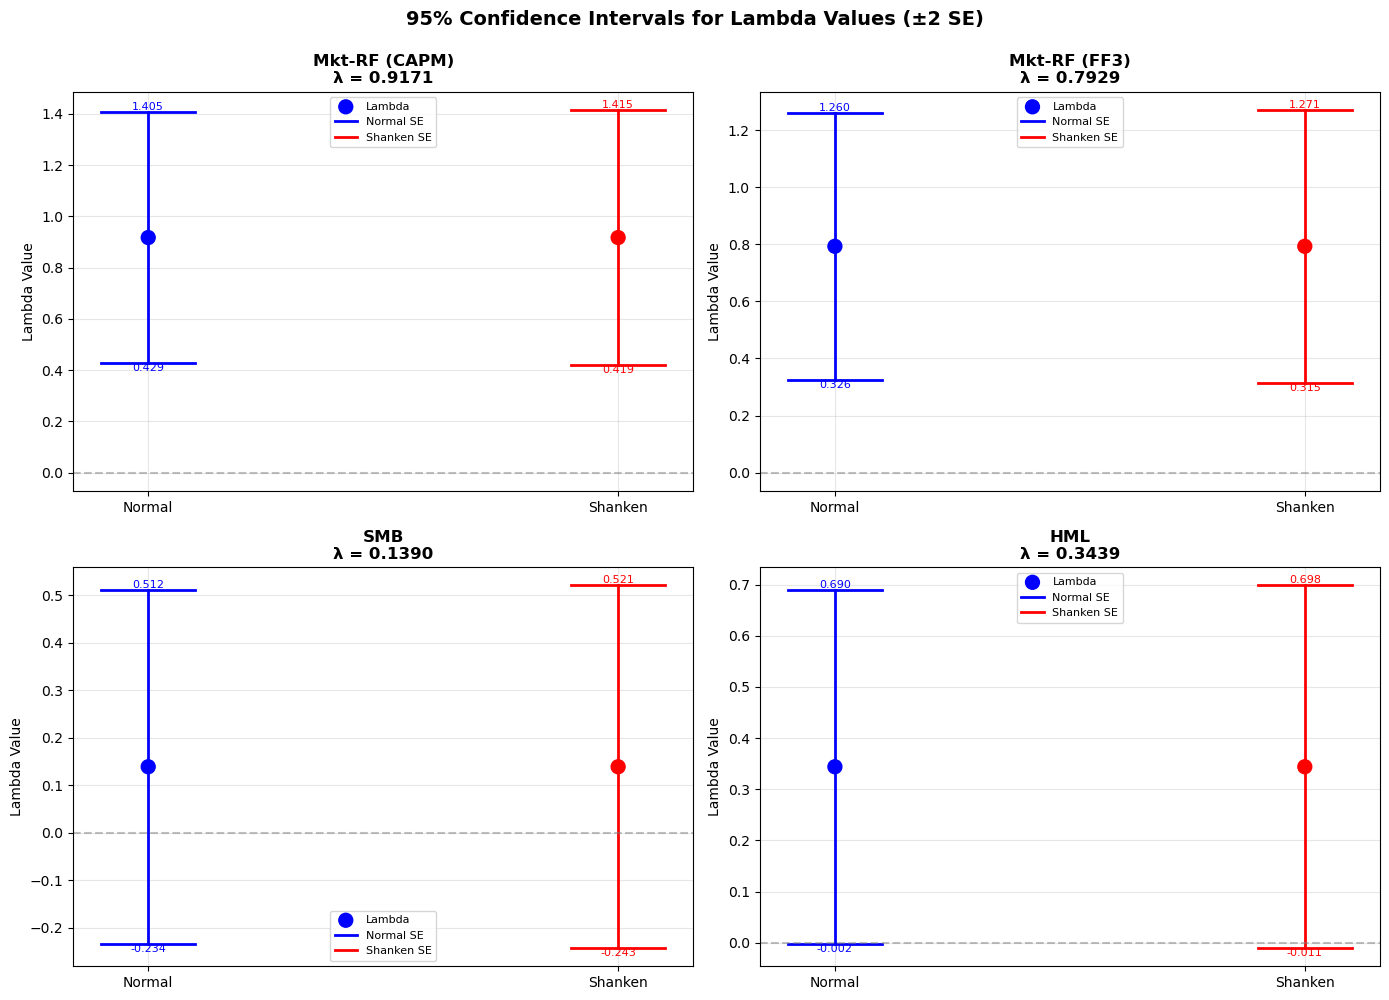


Confidence Interval Summary (±2 SE):

Mkt-RF (CAPM):
  Lambda: 0.917079
  Normal CI: [0.429199, 1.404959]
  Shanken CI: [0.418947, 1.415211]
  CI Width (Normal): 0.975760
  CI Width (Shanken): 0.996264

Mkt-RF (FF3):
  Lambda: 0.792936
  Normal CI: [0.326226, 1.259646]
  Shanken CI: [0.314954, 1.270918]
  CI Width (Normal): 0.933420
  CI Width (Shanken): 0.955964

SMB:
  Lambda: 0.138971
  Normal CI: [-0.234279, 0.512221]
  Shanken CI: [-0.243293, 0.521235]
  CI Width (Normal): 0.746500
  CI Width (Shanken): 0.764528

HML:
  Lambda: 0.343932
  Normal CI: [-0.002220, 0.690084]
  Shanken CI: [-0.010580, 0.698444]
  CI Width (Normal): 0.692304
  CI Width (Shanken): 0.709024


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
factors = ['Mkt-RF (CAPM)', 'Mkt-RF (FF3)', 'SMB', 'HML']
lambdas = [0.917079, 0.792936, 0.138971, 0.343932]
se_normal = [0.24394, 0.233355, 0.186625, 0.173076]
se_shanken = [0.249066, 0.238991, 0.191132, 0.177256]

# Calculate confidence intervals (±2 SE)
ci_normal_lower = [l - 2*se for l, se in zip(lambdas, se_normal)]
ci_normal_upper = [l + 2*se for l, se in zip(lambdas, se_normal)]
ci_shanken_lower = [l - 2*se for l, se in zip(lambdas, se_shanken)]
ci_shanken_upper = [l + 2*se for l, se in zip(lambdas, se_shanken)]

# Create subplots for each factor
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (ax, factor) in enumerate(zip(axes, factors)):
    # Plot lambda point
    ax.scatter([1, 2], [lambdas[i], lambdas[i]], s=100, c=['blue', 'red'], 
               zorder=3, label='Lambda')
    
    # Plot normal CI
    ax.plot([1, 1], [ci_normal_lower[i], ci_normal_upper[i]], 
            'b-', linewidth=2, label='Normal SE')
    ax.plot([0.9, 1.1], [ci_normal_lower[i], ci_normal_lower[i]], 'b-', linewidth=2)
    ax.plot([0.9, 1.1], [ci_normal_upper[i], ci_normal_upper[i]], 'b-', linewidth=2)
    
    # Plot Shanken CI
    ax.plot([2, 2], [ci_shanken_lower[i], ci_shanken_upper[i]], 
            'r-', linewidth=2, label='Shanken SE')
    ax.plot([1.9, 2.1], [ci_shanken_lower[i], ci_shanken_lower[i]], 'r-', linewidth=2)
    ax.plot([1.9, 2.1], [ci_shanken_upper[i], ci_shanken_upper[i]], 'r-', linewidth=2)
    
    # Add horizontal line at 0
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Labels and formatting
    ax.set_title(f'{factor}\nλ = {lambdas[i]:.4f}', fontsize=12, fontweight='bold')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Normal', 'Shanken'])
    ax.set_ylabel('Lambda Value', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)
    
    # Add text annotations for CI bounds
    ax.text(1, ci_normal_upper[i], f'{ci_normal_upper[i]:.3f}', 
            ha='center', va='bottom', fontsize=8, color='blue')
    ax.text(1, ci_normal_lower[i], f'{ci_normal_lower[i]:.3f}', 
            ha='center', va='top', fontsize=8, color='blue')
    ax.text(2, ci_shanken_upper[i], f'{ci_shanken_upper[i]:.3f}', 
            ha='center', va='bottom', fontsize=8, color='red')
    ax.text(2, ci_shanken_lower[i], f'{ci_shanken_lower[i]:.3f}', 
            ha='center', va='top', fontsize=8, color='red')

plt.suptitle('95% Confidence Intervals for Lambda Values (±2 SE)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nConfidence Interval Summary (±2 SE):")
print("="*70)
for i, factor in enumerate(factors):
    print(f"\n{factor}:")
    print(f"  Lambda: {lambdas[i]:.6f}")
    print(f"  Normal CI: [{ci_normal_lower[i]:.6f}, {ci_normal_upper[i]:.6f}]")
    print(f"  Shanken CI: [{ci_shanken_lower[i]:.6f}, {ci_shanken_upper[i]:.6f}]")
    print(f"  CI Width (Normal): {ci_normal_upper[i] - ci_normal_lower[i]:.6f}")
    print(f"  CI Width (Shanken): {ci_shanken_upper[i] - ci_shanken_lower[i]:.6f}")